In [1]:
# !pip install tushare
import numpy as np
import pandas as pd

from math import sqrt
from sklearn.metrics import mean_squared_error,mean_absolute_error
import os
import bcolz
import tushare as ts
import baostock as bs
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'bcolz'

In [2]:
os.chdir('/www/stocks/')



# import imp
# imp.reload(newfeature)

def getbaostock(symbol, start='2015-01-01', end='2019-10-25', ktype='D'):
    rs = bs.query_history_k_data_plus(symbol,
        "date,code,open,high,low,close,volume,amount",#turn,pctChg,peTTM,psTTM,pcfNcfTTM,pbMRQ,isST
        start_date=start, end_date=end,
        frequency=ktype, adjustflag="2")

    data_list = []
    while (rs.error_code == '0') & rs.next():
        data_list.append(rs.get_row_data())
    result = pd.DataFrame(data_list, columns=rs.fields)
    result=result[data['volume']>0].sort_values('date')
    result['p_change']=10*result.close.diff()/result.close.shift()
    result.set_index('date',inplace=True)
    
    return result  

def getcsvdata(symbol):
    """获取一只股票的数据，切分成特征和标签，收盘价返回"""
    path1='/www/stocks/'
    # result = pd.read_csv(path1+symbol+'.csv')
    if os.path.exists(path1+symbol):

        columns=pd.read_csv(path1+'data.csv').columns
        # print(columns)
        save= bcolz.open(rootdir=path1+symbol, mode='a')
        result=pd.DataFrame(save,columns=columns[1:])

    if result.shape[0]>1 and result.shape[1]>200:
    # result=result[result['volume']>0].sort_values('date')
    # result['p_change']=10*result.close.diff()/result.close.shift()
        # result.set_index('date',inplace=True)

        data_y=0.1*result[['resultclass2','resultmin2','resultmax2','resultrelclass2','resultclass4','resultmin4',
                           'resultmax4','resultrelclass4','resultclass7','resultmin7','resultmax7','resultrelclass7',
                           'resultclass10','resultmin10','resultmax10','resultrelclass10']].values
        data_x=result.drop(['resultclass2','resultmin2','resultmax2','resultrelclass2','resultclass4','resultmin4',
                           'resultmax4','resultrelclass4','resultclass7','resultmin7','resultmax7','resultrelclass7',
                           'resultclass10','resultmin10','resultmax10','resultrelclass10'],axis=1)
        data_close=result[['close']]
        return data_x,data_y,data_close
    else:
        return pd.DataFrame(),[],[]

def get_quantiles(data,x=10): # 分箱，标签结果分类
    bins=np.r_[-1e100,[np.round(np.quantile(data, i/x),3) for i in range(1,x)],1e100]
    return bins


  
def LSTMcutdatas(data_x,data_y,sequence_length,days,r=1,isfeature=1):

#生成LSTM程序
# r=int(240/int(dtype))，即一天包含多少个计时周期，如60分钟k线包含240/60=4

    newdata = []
    mm=15

#拼合成LSTM的结构

    for index in range(0,len(data_x) - sequence_length,r):

        rangedata=data_x[index: index + sequence_length].copy()  # 获取10个样本数据(即后10天的数据)

### 这是用feature,什么都不用干
#         for ii in ['ma5','ma10','ma20']:
#             rangedata[[ii]]=(rangedata[[ii]])/(rangedata[[ii]].iloc[0])-1
#             rangedata['ma5']=(rangedata['ma5'])/(rangedata['ma5'][0])-1
#             rangedata['ma10']=(rangedata['ma10'])/(rangedata['ma10'][0])-1
#             rangedata['ma20']=(rangedata['ma20'])/(rangedata['ma20'][0])-1

# #这个是不用feature的操作
        x=data_x.loc[index,'close'].copy()  # 获取今天的收盘价
        if isfeature==1:
            rangedata['close']=10*rangedata['close']/(0.01+x)-10  # 计算10天内每天相对第1天的累计涨幅
            rangedata['open']=10*rangedata['open']/(0.01+x)-10
            rangedata['high']=10*rangedata['high']/(0.01+x)-10
            rangedata['low']=10*rangedata['low']/(0.01+x)-10

        elif isfeature!=1:
            rangedata=10*(rangedata)/(rangedata.iloc[0])-10
        newdata.append(rangedata.values)

    newdata = np.array(newdata)
    
    x_train = newdata[:-100, :].astype('float16') # 切分训练，校验，预测集, 训练集1991-100天前数据
    x_test = newdata[-100:-10, :].astype('float16')  # 测试集100天前到10天前数据
    x_pred = newdata[-10:, :].astype('float16')

    y_new=data_y[::r]  # 按r步长切片
    y_train = y_new[int(sequence_length/r):-100]
    y_test = y_new[-100:-10]
    
    return x_train,x_test,x_pred,y_train,y_test  # 预测集每标签值？

def ltsmmodel(xshape,yshape):
#创建模型
    from keras import optimizers

    from keras.models import Sequential
    from keras.layers import LSTM,Dense, Dropout, Flatten,Activation
    from keras.layers import Conv2D, MaxPooling2D
    from keras.layers.normalization import BatchNormalization

    model=Sequential()
    print(xshape)
    model.add(LSTM(units=1000,input_shape=(xshape[1],xshape[2]),return_sequences=True))  ##activation='softmax', 
    model.add(BatchNormalization())
    # model.add(Activation('tanh'))
    model.add(Dropout(0.3))
    
    model.add(LSTM(units=400,return_sequences=True))  ##activation='softmax', 
    model.add(BatchNormalization())
    # model.add(Activation('tanh'))
    model.add(Dropout(0.3))

    model.add(LSTM(units=200,return_sequences=True))  ##activation='softmax', 
    model.add(BatchNormalization())
    # model.add(Activation('tanh'))
    model.add(Dropout(0.3))
    
    model.add(LSTM(units=100)), 
    model.add(Dropout(0.2))
    model.add(Dense(units=yshape[1]))
    model.add(Activation('linear'))

    sgd = optimizers.SGD(lr=0.01, clipnorm=1.,decay=1e-6, momentum=0.9, nesterov=True)
#     model.compile(loss='binary_crossentropy', optimizer=sgd)
    model.compile(optimizer=sgd,loss='mean_absolute_error')#optimizer='adam',
    return model

def fitpredict(model,data):
    pass
    return RMSE(y_test[:-1], predictions[:-1]), predictions[-1][0]

def collectDatas(stocks,days,r,sequence_length):
    #将指数、所有数据拼合成一个collect
    j=0
    path1='/content/stockdata/'
    x_trains=pd.DataFrame()
    for symbol in stocks:
        if os.path.exists(path1+symbol):
            data_x,data_y,data_close=getcsvdata(symbol)
            # print(symbol,data_x.shape)

            #不同的数据获取方式
        #     data=ts.get_hist_data(symbol)
            # data=getbaostock(symbol)
        #     print(symbol,data.shape,szzs.head(2))

            if len(data_x)>300:
                j+=1
                # y_price,data_x,data_y=predealData(data,szzs,days,10,r,1)
                x_train,x_test,x_pred,y_train,y_test=LSTMcutdatas(data_x,data_y,sequence_length,days,r)
                if j%50==0:
                    print(j,symbol,data_x.shape)

                if x_train[np.isnan(x_train)].any():
                    print(j,'eerror', symbol,data_x.shape)
                elif data_x.shape[1]>200:
                    if j==1:
                        x_trains,x_tests,x_preds,y_trains,y_tests=x_train,x_test,x_pred,y_train,y_test
                    else:

                        x_trains=np.append(x_trains,x_train,axis=0)  # 多股票同时带入模型的，把每个股票的训练集拼接在一起
                        y_trains=np.append(y_trains,y_train,axis=0)  # 这里只有一只股票，所以没啥区别
                        x_tests=np.append(x_tests,x_test,axis=0)
                        y_tests=np.append(y_tests,y_test,axis=0)
                        x_preds=np.append(x_preds,x_pred,axis=0)

    if len(x_trains)>0:
        print(x_trains.shape)
        return x_trains,x_tests,x_preds,y_trains,y_tests
    else:
        print('no data')
        
        
        
def lstmpredict(model, x_trains,x_tests,x_preds,y_trains,y_tests, seq_len=50,epochs=30,days=5,r=1):
    #模型训练、并画图

    sequence_length=seq_len
    if len(x_trains)>300:

        history = model.fit(x_trains[:],y_trains[:],validation_data=(x_tests,y_tests)
           ,batch_size=128 * 2,epochs=epochs)
        #epochs=epochs,steps_per_epoch=30,validation_data=(x_tests,y_tests),validation_split=0.3
        predictions=model.predict(x_tests)  # 预测校验集结果
        predictions_new=model.predict(x_preds)   # 预测测试集结果   


        plt.figure(figsize=(24,15))

        ax=plt.subplot(311)

        ax.plot(history.history['loss'])
        ax.plot(history.history['val_loss'])
        ax.legend(['train','validation'],loc='upper right')

        ax=plt.subplot(312)
        ax.plot(y_tests[-200:,0],c='g')
        ax.plot([0,200],[0.5,0.5],c='y')
        ax.plot(np.r_[predictions[-200:,0]],c='r')
        ax.legend(['true','predictions'],loc='upper right')

        
        

#         model.fit(x_tests[:],y_tests[:],
#             epochs=int(epochs/10),batch_size=128 * 2)
#         predictions=model.predict(x_tests)        
#         predictions_new=model.predict(x_preds)    


#         plt.figure(figsize=(24,15))
#         ax=plt.subplot(311)
#         ax.plot(y_tests[-100:],c='g')
#         ax.plot([0,100],[0.5,0.5],c='y')
#         ax.plot(np.r_[predictions[-100:],predictions_new[:]],c='r')

        return  1
        # return np.round(model.evaluate(x_tests, y_tests))
    else:
        return 'data too short',0


FileNotFoundError: [WinError 3] 系统找不到指定的路径。: '/www/stocks/'

In [14]:

# stocks=['000001','000002','000005']

# stocks=ts.get_stock_basics().index.values
# szzs=ts.get_hist_data('sh')

# stocks=pd.read_csv('stocks.csv').code.str.replace('\'','').values
# szzs=pd.read_csv('index/sh.000001.csv').set_index('date')
# tempdata=pd.read_csv(path1+'/000001.csv').set_index('date')
# tempdata.head()

In [30]:
days=5
r=1
sequence_length=10
stocks=['000541']
x_trains,x_tests,x_preds,y_trains,y_tests=collectDatas(stocks,days,r,sequence_length)
print(x_trains.shape,x_tests.shape,y_trains.shape,y_tests.shape)



(24078, 10, 284)
(24078, 10, 284) (24078, 8)


In [31]:
# ##新建模型，如果模型不变，可以不需要
# model=ltsmmodel(x_trains.shape,y_trains.shape)
# model.summary()

from keras.models import load_model
model=load_model('lstm-16.h5')  # 加载预训练过的lstm-16模型

print(x_tests.shape,y_tests.shape)
absloss=lstmpredict(model,x_trains,x_tests,x_preds,y_trains,y_tests, 50,5,5,1)


(24078, 10, 284) (3240, 10, 284) (24078, 8) (3240, 8)
(3240, 10, 284) (3240, 8)
Train on 24078 samples, validate on 3240 samples
Epoch 1/5
17920/24078 [=====================>........] - ETA: 40s - loss: 0.24

limit_output extension: Maximum message size of 10000 exceeded with 10055 characters

0 ,mean_absolute_error 0.22397358080303229 ,precision 0.5139427656898983 ,f1_score 0.5800277883939358 ,topacc 0.5408560311284046
1 ,mean_absolute_error 0.23487603023556283 ,precision 0.5347214091233444 ,f1_score 0.5822445800469976 ,topacc 0.6174863387978142
2 ,mean_absolute_error 0.22173733293550252 ,precision 0.5199215028769576 ,f1_score 0.5995630537542987 ,topacc 0.5752427184466019
3 ,mean_absolute_error 0.23671823336202422 ,precision 0.5366304487530316 ,f1_score 0.5883980762101254 ,topacc 0.6313725490196078
4 ,mean_absolute_error 0.22284755725735503 ,precision 0.5184868345844607 ,f1_score 0.5900756536559005 ,topacc 0.5607675906183369
5 ,mean_absolute_error 0.23567493959249536 ,precision 0.5299468077600334 ,f1_score 0.5801164920230341 ,topacc 0.6064030131826742
6 ,mean_absolute_error 0.22147750459887364 ,precision 0.5199024501771902 ,f1_score 0.6010628559291817 ,topacc 0.5771144278606966
7 ,mean_absolute_error 0.23482690168015752 ,precision 0.5375291905145654 ,f1_score 0.588825119492

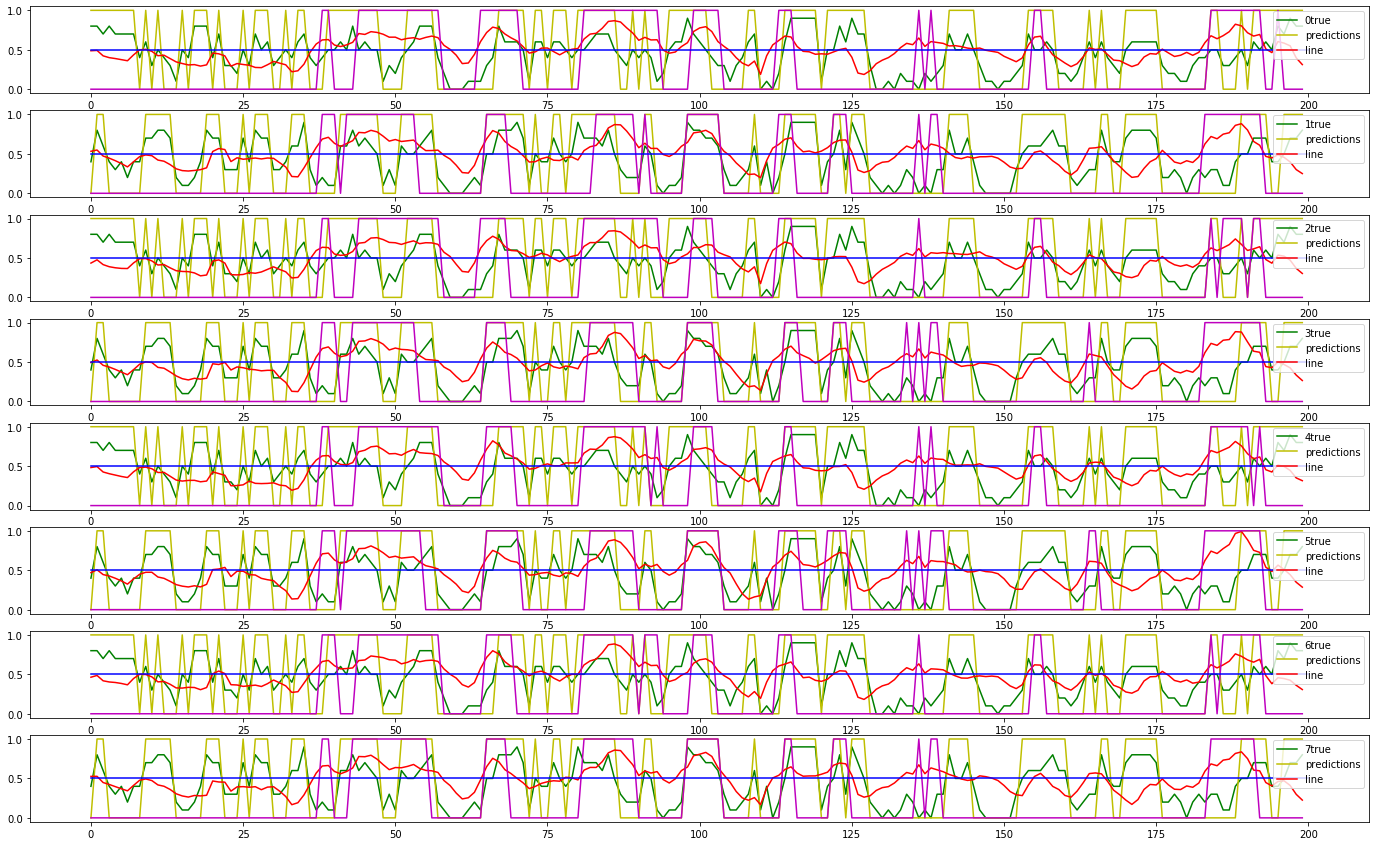

In [34]:
def maxaccuarcy(ypreds,ytrue):
    ypredtrue=ytrue[ypreds==1]
    
    return ypredtrue.sum()/ypreds.sum()

# x_tests=x_trains
# y_tests=y_trains
predictions=model.predict(x_tests)        
predictions_new=model.predict(x_preds) 

print(pd.DataFrame(predictions_new,columns=[
    'resultclass2','resultmin2','resultmax2','resultrelclass2','resultclass4','resultmin4',
    'resultmax4','resultrelclass4','resultclass7','resultmin7','resultmax7','resultrelclass7',
    'resultclass10','resultmin10','resultmax10','resultrelclass10']))
from sklearn.metrics import precision_score,recall_score,f1_score
# precision = precision_score(y_true, y_pred, average='macro')
# recall = recall_score(y_true, y_pred, average='micro')
# f1 = f1_score(y_true, y_pred, average='weighted')
trshold=0.7
plt.figure(figsize=(24,15))
predictions1=predictions.copy()
predictions1[predictions>trshold]=1
predictions1[predictions<=trshold]=0
predictions1_new=predictions_new.copy()
predictions1_new[predictions_new>trshold]=1
predictions1_new[predictions_new<=trshold]=0
# predictions1[predictions<=0.4]=0
y_tests1=y_tests.copy()
y_tests1[y_tests>0.75*trshold]=1
y_tests1[y_tests<=0.75*trshold]=0
# y_tests1[y_tests<=0.4]=0


for i in range(8):

    ax=plt.subplot('81'+str(i+1))
    ax.plot(y_tests[:,i],c='g')
    ax.plot(y_tests1[:,i],c='y')
    ax.plot(np.r_[predictions[:,i],predictions_new[:,i]],c='r')
    ax.plot(np.r_[predictions1[:,i],predictions1_new[:,i]],c='m')
    ax.plot([0,200],[0.5,0.5],c='b')
    print(i,',mean_absolute_error',mean_absolute_error(predictions[:,i],y_tests[:,i]), 
          ',precision',precision_score(predictions1[:,i], y_tests1[:,i], average='macro'),
          ',f1_score',f1_score(predictions1[:,i], y_tests1[:,i], average='weighted'),
          ',topacc',maxaccuarcy(predictions1[:,i], y_tests1[:,i])
         )
    ax.legend([str(i)+'true','predictions','line',],loc='upper right')# print predict()s
    
